# Running age model on many stars and comparing with Jason's ages.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from isochrones.mist import MIST_Isochrone
from isochrones import StarModel
mist = MIST_Isochrone()
import emcee
import priors
import corner
import h5py

Estimate B-V colours for stars based on their G_BP - G_RP colours. This is a crude estimated used only if a gyro-only lhf is used.

In [3]:
def bv_2_bprp(bv):
    """
    Numbers from https://arxiv.org/pdf/1008.0815.pdf
    """
    a, b, c, d = .0981, 1.4290, -.0269, .0061  # sigma = .43
    return a + b*bv + c*bv**2 + d*bv**3

def bprp_2_bv(bprp):
    """
    Try to find the analytic version of this, please!
    """
    bv_iter = np.linspace(0., 2., 10000)
    bprp_pred = [bv_2_bprp(bv) for bv in bv_iter]
    diffs = bprp - np.array(bprp_pred)
    # plt.plot(bprp_pred, diffs**2)
    return bv_iter[np.argmin(diffs**2)]

Define the gyrochronology model. I'm using the Barnes (2003) functional form with my (2015) parameters.

In [4]:
def gyro_model(ln_age, bv):
    """
    Given a B-V colour and an age, predict a rotation period.
    Returns log(age) in Myr.
    parameters:
    ----------
    logage: (array)
        The log age of a star: log10(age) in years.
    bv: (array)
        The B-V colour of a star.
    """
    age_myr = (10**ln_age)*1e-6
    
    a, b, c, n = [.4, .31, .45, .55]
    
    # return a*(age_myr)**n * (bv - c)**b
    log_P = n*np.log10(age_myr) + np.log10(a) + b*np.log10(bv-c)
    return 10**log_P

Define the log prior and the log posterior functions.

In [5]:
def lnprior(params):
    """
    lnprior on all parameters.
    params need to be linear except age which is log10(age [yr]).
    """
    
    # log Priors over age, metallicity and distance. (The priors in priors.py are not in log)
    age_prior = np.log(priors.age_prior(params[1]))
    feh_prior = np.log(priors.feh_prior(params[2]))
    distance_prior = np.log(priors.distance_prior(np.exp(params[3])))

    # Uniform prior on extinction.
    mAv = (0 <= params[4]) * (params[4] < 1)  # Prior on A_v
    mAv = mAv == 1
    
    # Uniform prior on mass
    m = (-20 < params[0]) * (params[0]) < 20  # Broad bounds on mass.
            
    if mAv and m and np.isfinite(age_prior) and np.isfinite(distance_prior):
        return age_prior + feh_prior + distance_prior
    
    else:
        return -np.inf

    
def lnprob(lnparams, *args):
    # Transform mass and distance back to linear.
    params = lnparams*1
    params[0] = np.exp(lnparams[0])
    params[3] = np.exp(lnparams[3])
    
    mod, period, period_err, bv_est, gyro_only, iso_only = args
    
    B = mist.mag["B"](*params)
    V = mist.mag["V"](*params)
    bv = B-V
    
    # If the prior is -inf, don't even try to calculate the isochronal likelihood.
    lnpr = lnprior(params)
    if lnpr == -np.inf:
        return lnpr
    
    else:
    
        if iso_only:
            return mod.lnlike(params) + lnpr
        
        else:
            if bv > .45:
                gyro_lnlike = -.5*((period - gyro_model(params[1], bv)) /period_err)**2
            else:
                gyro_lnlike = 0
    
        # B-V is estimated from mass, etc, so you need to use a different B-V estimate if gyro_only.
        if gyro_only:
            return -.5*((period - gyro_model(params[1], bv_est)) /period_err)**2 + lnpr
    
        else:
            return mod.lnlike(params) + gyro_lnlike + lnpr

Define the function that infers the age of a single star via MCMC.

In [115]:
def inits(df, star_ind):
    print("star_ind (inits) = ", star_ind)
    # Set the initial values
    mass_init = df.mass.values[star_ind]
    age_init = 2e9
    feh_init = df.feh.values[star_ind]
    distance_init = 1./df.parallax.values[star_ind]
    Av_init = df.Av.values[star_ind]

    # sample in ln(mass), log10(age) and ln(distance).
    p_init = np.array([np.log(mass_init), np.log10(age_init), feh_init, np.log(distance_init), Av_init])

    # Set up the StarModel object needed to calculate the likelihood. 
    param_dict = {"J": (df.J.values[star_ind], df.J_err.values[star_ind]),
                  "H": (df.H.values[star_ind], df.H_err.values[star_ind]),
                  "K": (df.K.values[star_ind], df.K_err.values[star_ind]),
                  "Kepler": (df.kepmag.values[star_ind], df.kepmag_err.values[star_ind]),
                  "teff": (df.teff.values[star_ind], df.teff_err1.values[star_ind]),
                  "logg": (df.logg.values[star_ind], df.logg_err1.values[star_ind]),
                  "feh": (df.feh.values[star_ind], df.feh_err1.values[star_ind]),
                  "parallax": (df.parallax.values[star_ind],
                  (df.parallax_error.values[star_ind]))}  # Isochrones.py takes milliarcseconds
    mod = StarModel(mist, **param_dict)
    return param_dict, p_init, mod


def run_mcmc(df, param_dict, p_init, mod, star_ind, nwalkers=24, gyro_only=False, iso_only=False):
    print("star_ind (run_mcmc) = ", star_ind)

    ndim = 5
    args = [mod, df.period.values[star_ind], 
            .5*(df.period_errm.values[star_ind] + df.period_errp.values[star_ind]),
            df.BV_color.values[star_ind], gyro_only, iso_only]

    p0 = [p_init + np.random.randn(ndim)*1e-4 for i in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=args)
    p0, _, _ = sampler.run_mcmc(p0, 20000);
    
    samples = sampler.flatchain
    samples[:, 0] = np.exp(sampler.flatchain[:, 0])
    samples[:, 3] = np.exp(sampler.flatchain[:, 3])
    return samples

Run mcmc on multiple stars and save the samples.

In [114]:
# Load data
df = pd.read_csv("kane_cks_tdmra_dr2.csv")
df.keys()

Index(['Unnamed: 0', 'koi_id', 'planet_designation', 'p_orb_days', 'a_AU',
       'r_pl_earth', 'teff_x', 'r_star_rsol', 'insolation_flux_F_E', 'KOI',
       ...
       'prov_sec', 'nconfp', 'nkoi', 'ntce', 'jmag', 'hmag', 'kmag', 'planet?',
       'kepler_gaia_ang_dist', 'int_kepid'],
      dtype='object', length=245)

In [94]:
RESULTS_DIR = "samples"

def linear_error(log_mu, log_err):
    return abs(10**log_mu - 10**(log_mu + log_errx))

In [116]:
# Load the Sanders catalogue and merge with the CKS one.
file = "gaia_spectro.hdf5"
data = Table.read(file)
sanders = data.to_pandas()
sgdf = pd.merge(df, sanders, on="source_id", suffixes=["", "_sanders"])

Cut out giants.

In [117]:
m = 4.2 < sgdf.logg.values
sdf = sgdf.iloc[m]

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


In [118]:
# Create estimated colour column.
bv_color = []
for i in range(np.shape(sdf)[0]):
    bv_color.append(bprp_2_bv(sdf.phot_bp_mean_mag.values[i] - sdf.phot_rp_mean_mag.values[i]))

In [119]:
# Create df
cks_df = pd.DataFrame(dict({"source_id": sdf.source_id,
                            "J": sdf.jmag.values, 
                            "J_err": sdf.jmag.values*.05,
                            "H": sdf.hmag.values,
                            "H_err": sdf.hmag.values*.05,
                            "K": sdf.kmag.values,
                            "K_err": sdf.kmag.values*.05,
                            "kepmag": sdf.kepmag.values,
                            "kepmag_err": sdf.kepmag.values*.05,
                            "mass": sdf.iso_smass.values, 
                            "feh": sdf.cks_smet.values,
                            "feh_err1": sdf.cks_smet_err1.values,
                            "parallax": sdf.parallax.values,
                            "parallax_error": sdf.parallax_error.values,
                            "teff": sdf.cks_steff.values,
                            "teff_err1": sdf.cks_steff_err1.values,
                            "logg": sdf.cks_slogg.values,
                            "logg_err1": sdf.cks_slogg_err1.values,
                            "BV_color": np.array(bv_color),
                            "period": sdf.period.values,
                            "period_errm": sdf.period_errm.values,
                            "period_errp": sdf.period_errp.values,
                            "Av": 10**sdf.log10_av.values,
                            }))

In [120]:
print(cks_df.keys())

Index(['Av', 'BV_color', 'H', 'H_err', 'J', 'J_err', 'K', 'K_err', 'feh',
       'feh_err1', 'kepmag', 'kepmag_err', 'logg', 'logg_err1', 'mass',
       'parallax', 'parallax_error', 'period', 'period_errm', 'period_errp',
       'source_id', 'teff', 'teff_err1'],
      dtype='object')


In [126]:
nstars = 1
ages, age_errp, age_errm = [np.zeros(nstars) for i in range(3)]

def ensemble(nstars, gyro_only=False, iso_only=False):
    
    for star in range(nstars):
        print(cks_df.source_id.values[star])
        param_dict, p_init, mod = inits(cks_df, star)
        samples = run_mcmc(cks_df, param_dict, p_init, mod, star, gyro_only=gyro_only, iso_only=iso_only)
        
        ages[star] = np.median(samples[:, 1])
        
        f = h5py.File("samples/{0}.h5".format(star), "w")
        data = f.create_dataset("samples", np.shape(samples))
        data[:, :] = samples
        f.close()
        
        return samples
        
samples = ensemble(nstars)

2.0732772002376945e+18


AssertionError: 

In [122]:
print(np.shape(samples))

(480000, 5)


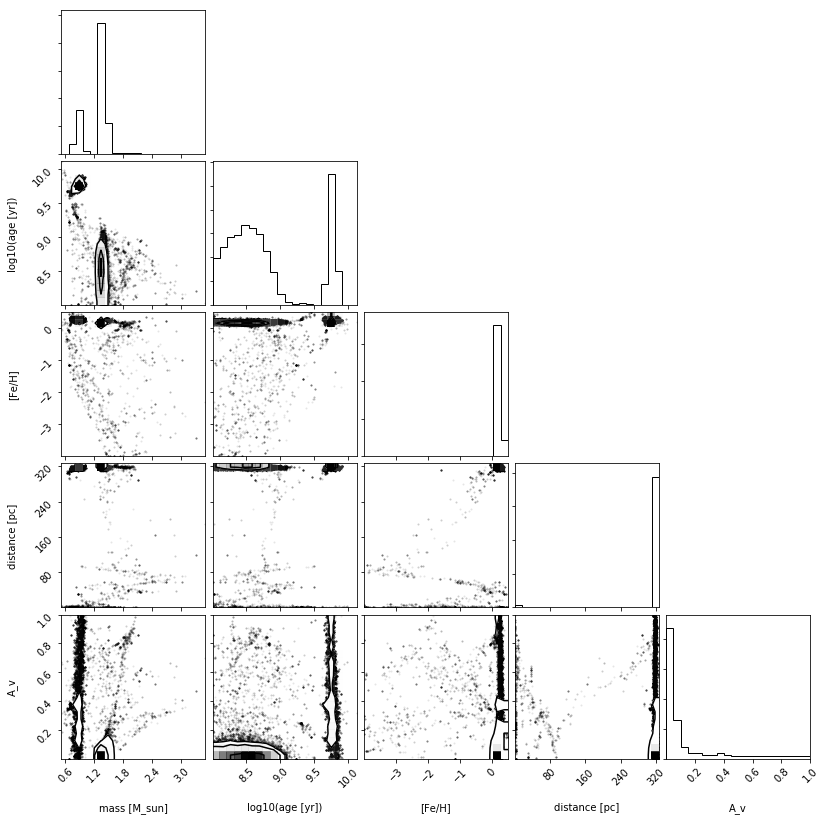

In [124]:
corner.corner(samples[400000:, :], labels=["mass [M_sun]", "log10(age [yr])", "[Fe/H]", "distance [pc]", "A_v"]);

Text(0.5,0,'Age [Gyr]')

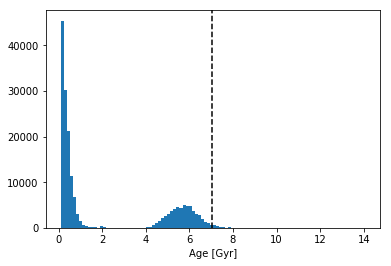

In [125]:
plt.hist(1e-9*(10**samples[300000:, 1]), 100);
plt.axvline(10**sdf.log10_age.values[0], color="k", ls="--")
plt.xlabel("Age [Gyr]")